## Overview

This will:

Determine surface melt. For C-band it is a 3 dB decrease from winter backscatter
Melt info visualization
Later: determine when snow melts out, visualize date uncertainties better

MAIN TASK: stack the images together and cutout to area

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX

#capture
from datetime import datetime,timedelta
import glob
import json # for loads
import os
from pathlib import Path
import pytz
import re
import shutil
import asf_search as asf
from zipfile import ZipFile
import time

from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('Agg')
#Writing Support Functions:

import numpy as np
from osgeo import gdal,osr

from IPython.display import HTML, display, clear_output, Markdown
    
from hyp3_sdk import Batch, HyP3

import opensarlab_lib as asfn

URLWidget()

In [2]:
#Set directories
# data_dir=Path('test')

# analysis_directory = Path.cwd()/data_dir
# products_path = analysis_directory/"rtc_products"
# clipped_path = analysis_directory/"rtc_clipped"

##NAME PROJECT###
projdir = Path.home()/"GlacierSARdata"
projname = 'Harding'
year = 2021
data_dir=Path(f'{projdir}/{projname}/{str(year)}')
pols = ['VV','VH']

# Setting Paths
analysis_directory = Path.cwd()/data_dir
print(f"analysis_directory: {analysis_directory}")

download_path = analysis_directory/"rtc_download"
# download_path.mkdir()
products_path = analysis_directory/"rtc_products"
# products_path.mkdir()
clipped_path = analysis_directory/"rtc_clipped"

# print(download_path)
# print(products_path)
# print(clipped_path)

# os.makedirs(data_dir,exist_ok=True)
# os.makedirs(download_path,exist_ok=True)
# os.makedirs(products_path,exist_ok=True)
# os.makedirs(analysis_directory/"figures",exist_ok=True)
# os.makedirs(clipped_path,exist_ok=True)
# for pol in pols:
#     os.makedirs(clipped_path/pol,exist_ok=True)

analysis_directory: /home/jovyan/GlacierSARdata/Harding/2021


In [3]:
usepol = 'VV'
# usepol = 'VH'

(arraykey,pnamelist,mnamelist,mdatelist,mpflist,mpfulist) = np.load(f'{str(analysis_directory)}/imgmeta_{usepol}.npy',allow_pickle=True)
mpfunique = np.unique(mpfulist)

In [8]:
# mpfulist

In [4]:
#Put data into array
#consider caution
#quadrants?
#hydrants?


def opendata(pnamelist):
    shp = np.shape(gdal.Open(pnamelist[0]).ReadAsArray())
    # print(shp)
    data = np.empty(shape=[len(pnamelist),shp[0],shp[1]])
    for i,name in enumerate(pnamelist):
        cdata = gdal.Open(name).ReadAsArray()
        cdata[cdata==0]=np.nan
        cdata[np.abs(cdata)>=60]=np.nan
        data[i,:]=cdata
        # print(cdata[0,0])
        # data = np.append(data,[cdata],axis=0)
    # print(np.shape(data))
    # data[np.abs(data)>60]=np.nan
    return data

# del(data)
data = opendata(pnamelist)

## Plot Images

In [6]:
# pols = ['VV']

# for pol in pols:
#     #Make some darn pretty pictures:
#     fileloc = clipped_path/pol
#     filelist = glob.glob(f'{fileloc}/*')
#     # figurepath = fileloc.replace('rtc_clipped','figures')
#     figurepath = data_dir/'figures'
#     for file in filelist:
#         # fname = file.split('rtc_clipped/')[1]
#         fname = file.replace(str(fileloc),str(figurepath))
#         # fname = fname.replace('_VV.tif','.png')
#         fname = fname.replace('S1A_','')
#         fname = fname.replace('S1B_','')
#         fname = fname.replace('.tif','.png')
#         # print(file)
#         ds = gdal.Open(file)
#         sarmap = ds.ReadAsArray()
#         ds = None
#         sarmap[sarmap<-40]=np.nan
#         plt.figure(figsize=(7,7))
#         plt.imshow(sarmap,vmin=-20,vmax=2,cmap='Greys_r')
#         ax = plt.gca()
#         ax.axes.xaxis.set_visible(False)
#         ax.axes.yaxis.set_visible(False)
#         plt.savefig(fname,bbox_inches='tight')
#         plt.close()
#         # print(np.shape(sarmap))

#         # print(file)
#         # print(fname)

#     # print(filelist)
    
# pols = ['VV','VH']

In [8]:
# fname

What I want some things to do:

1. find the winter mean BS value for each mpfu
2. adjust each ts so that it is all lined up on that mean value
3. then do the 1 day rasar thing.
4. then make scaling day-to-day images of it all

---OR---

Just put linearly scaling differences between missing pixels? To do this I need:

1. find the winter mean bs value for each pixel and mpfu
2. adjust each image so that the bs values line up
3. Create the missing values? This will be expensive as I also need to know the time diff between each one. What if I create an NxN timediff matrix where N is the timediff of each image pair (in sec I guess?) All of this is predicated for finding (and indexing) nearest non-nan values on a list. I should test that

In [5]:
#winter mean alignment

# for mpf in mpfulist:
# type(mpfulist


#Process:
#take data, and the mpfulist or whatever. 
#for each pixel, get the avg 
#Then take the avg of all of those stacks
#Then apply the number that is the linear correction to that average for all those stacks.
#ALSO: does that correction number tell us anyhting interesting? What about the difference in that correction # between VV and VH

#test:
it,jt = 800,1200
plt.figure(figsize=(10,7))
# print(dstartstd)
for pfu in mpfunique:
    # dvec = data[mpfulist==pfu,it,jt]
  
    plt.plot(np.array(mdatelist)[mpfulist==pfu],data[mpfulist==pfu,it,jt],"-*",color='C0')
# plt.plot(np.array(mdatelist)[meltvec==1],data[meltvec==1,it,jt],"*",color='C1')
plt.ylim([-24,4])

wstart = datetime(year,1,1,0,0,0)
wend = datetime(year,4,1,1,0,0,0)
# wstart = datetime(year,10,15,0,0,0)
# wend = datetime(year,12,31,0,0,0)

# mpfunique
mpfu = np.array(mpfulist)
# print(mpfu)
klen,ilen,jlen = np.shape(data)
datelist = np.array(mdatelist)
if type(datelist)==tuple:
    datelist = np.array(datelist)

wmeanvals = np.zeros((len(mpfunique),ilen,jlen))
for m,mpf in enumerate(mpfunique):
    dstack = data[mpfu==mpf]     #datastack
    tlist = datelist[mpfu==mpf]  #datelist
    # print(np.shape(dstack))
    
    #dstack should data. Datelist should be list of dates.
    #Both of these should ONLY be from images of the same path-frame

    winterlist = np.zeros(len(tlist))
    winterlist[(tlist > wstart) & (tlist < wend)] = 1
    winterlist = np.array(winterlist,dtype=bool)
    dstack = dstack[winterlist]
    wmeanvals[m] = np.nanmean(dstack,axis=0)
    
wmeanmap=np.nanmean(wmeanvals,axis=0)

# plt.figure()
# plt.imshow(wmeanmap)
# plt.colorbar()

#Now do correction:
plt.figure(figsize=(12,6))
plt.imshow(wmeanmap)
plt.colorbar()


for m,mpf in enumerate(mpfunique):
    corrmap = wmeanmap - wmeanvals[m]
    data[mpfu==mpf] += corrmap

    plt.figure(figsize=(12,6))
    plt.imshow(corrmap,vmin=-6,vmax=6,cmap='RdBu_r')
    plt.colorbar()
    
plt.figure(figsize=(10,7))
# print(dstartstd)
for pfu in mpfunique:
    # dvec = data[mpfulist==pfu,it,jt]
  
    plt.plot(np.array(mdatelist)[mpfulist==pfu],data[mpfulist==pfu,it,jt],"-*",color='C0')
# plt.plot(np.array(mdatelist)[meltvec==1],data[meltvec==1,it,jt],"*",color='C1')
plt.ylim([-24,4])

print(wmeanmap[it,jt])
print(wmeanvals[:,it,jt])
#say val is 5 but wm is 2. So I want 5 + (2-5)







# def getwinteravg(dstack,datelist,wstart,wend):
#     #dstack should data. Datelist should be list of dates.
#     #Both of these should ONLY be from images of the same path-frame
#     if type(datelist)==tuple:
#         datelist = np.array(datelist)
#     winterlist = np.zeros(len(datelist))
#     winterlist[(datelist > wstart) & (datelist < wend)] = 1
#     winterlist = np.array(winterlist,dtype=bool)
#     dstack = dstack[winterlist]
#     meltdb = np.nanmean(dstack,axis=0)
#     return meltdb

/tmp/ipykernel_1805/738394629.py:51: RuntimeWarning: Mean of empty slice
  wmeanvals[m] = np.nanmean(dstack,axis=0)


-8.97516088031587
[         nan  -6.32323151          nan -11.75680379  -8.84544735]


yes


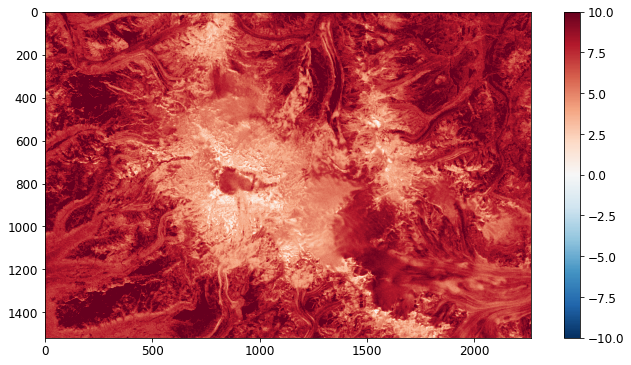

In [28]:
if usepol=='VV':
    wmeanVV = wmeanmap
    print('other')
if usepol=='VH':
    wmeanVH = wmeanmap
    print('yes')

plt.figure(figsize=(12,6))
plt.imshow(wmeanVV-wmeanVH,vmin=-10,vmax=10,cmap='RdBu_r')
plt.colorbar()

In [31]:
# plt.figure(figsize=(10,7))
# # print(dstartstd)
# for pfu in mpfunique:
#     # dvec = data[mpfulist==pfu,it,jt]
  
#     plt.plot(np.array(mdatelist)[mpfulist==pfu],data[mpfulist==pfu,it,jt],"-*",color='C0')
# # plt.plot(np.array(mdatelist)[meltvec==1],data[meltvec==1,it,jt],"*",color='C1')
# plt.ylim([-24,4])

# print(wmeanmap[ipt,jpt])
# print(wmeanvals[:,ipt,jpt])
# #say val is 5 but wm is 2. So I want 5 + (2-5)


# # def getwinteravg(dstack,datelist,wstart,wend):
# #     #dstack should data. Datelist should be list of dates.
# #     #Both of these should ONLY be from images of the same path-frame
# #     if type(datelist)==tuple:
# #         datelist = np.array(datelist)
# #     winterlist = np.zeros(len(datelist))
# #     winterlist[(datelist > wstart) & (datelist < wend)] = 1
# #     winterlist = np.array(winterlist,dtype=bool)
# #     dstack = dstack[winterlist]
# #     meltdb = np.nanmean(dstack,axis=0)
# #     return meltdb

In [32]:
# #test stuff

# a = np.arange(15.)
# for i in range(5,9):
#     a[i] = np.nan
# a[4]=7.0
# a[11]=np.nan
# a[12]=np.nan
# a[0] = np.nan
# print(a)


# # ind = np.where(~np.isnan(a))[0]
# # first, last = ind[0], ind[-1]
# # a[:first] = a[first]
# # a[last + 1:] = a[last]
# # print(a)
# acheck = a!=a
# print(acheck)
# idx = np.nonzero(a!=a)[0]
# print(idx)
# idxdiff = idx[1:]-idx[:-1]
# listlist = []
# ii=0
# while ii<len(idx):
#     i2 = ii
    
#     stoploop=True
#     while stoploop:
#         # print(idxdiff[i2])
#         if i2==len(idx)-1:
#             stoploop=False
#         elif idxdiff[i2]>1:
#             stoploop=False
#         i2+=1
#     print(ii)
#     print(i2)
#     print(' ')
#     listlist.append(idx[ii:i2])
#     ii=i2
# print(listlist)
# # print(0 in listlist[1])
# # test.append([2,3,4])
# # test.append([1,2])
# # print(test)
# a[idx]=a[idx[0]-1]+np.arange(len(idx))*(a[idx[-1]+1]-a[idx[0]-1])/(len(idx))
# print(a)
# # print(np.arange(len(idx))*(a[idx[-1]+1]-a[idx[0]-1])/len(idx))

In [6]:
# Create date matrix

def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

dllen = len(mdatelist)
datemat = np.zeros((dllen,dllen)) #timediff between points
for ii in range(dllen):
    for jj in range(dllen):
        if ii==jj:
            datemat[ii,jj]=0
        elif ii<jj:
            datemat[ii,jj]=timediff(mdatelist[ii],mdatelist[jj])
            datemat[jj,ii]=datemat[ii,jj]
print(np.shape(datemat))

(126, 126)


In [34]:
# datemat[5,5]
# timediff(dl2[1],dl2[0])
# del(datemat)

In [6]:
# #small scale test

# ipt,jpt = 100,101
# testvec = data[:,ipt,jpt]
# # print(testvec)
# # print(np.shape(testvec))
# # for i in testvec:
#     # print(i)
    
# bsvec = testvec
# bslen = len(bsvec)
# idx = np.nonzero(bsvec!=bsvec)[0] #magic here. Makes list of all nan entries.
# idxlen = len(idx)
# idxdiff = idx[1:]-idx[:-1]
# emptylist = []   #list of lists containing index values of sequential nans
# nn=0
# while nn<idxlen:
#     n2 = nn
    
#     stoploop=True
#     while stoploop:
#         # print(idxdiff[i2])
#         if n2==idxlen-1:
#             stoploop=False
#         elif idxdiff[n2]>1:
#             stoploop=False
#         n2+=1
#     # print(ii)
#     # print(i2)
#     # print(' ')
#     emptylist.append(idx[ii:i2])
#     nn=n2
# print(emptylist)

# plt.figure()
# plt.plot(bsvec,'.',markersize=20)

# #do interpolation:
# #FIX START AND END VALUES!!
# for empty in emptylist:
#     if 0 in empty:
#         pass
#     elif bslen-1 in empty:
#         pass
#     else:
#         s1 = empty[0]-1
#         s2 = empty[-1]+1
#         daydelta = datemat[s1,s2]
#         bsdelta = (bsvec[s2]-bsvec[s1])/daydelta
#         for ind in empty:
#             bsvec[ind] = bsvec[s1] + bsdelta*datemat[s1,ind]
            
# print(bsvec)
# plt.plot(bsvec,'.',markersize=10)        

NameError: name 'i2' is not defined

In [7]:
klen,ilen,jlen = np.shape(data)
t = time.time()
joblen = ilen

for ii in range(ilen):
    if ii % 10 == 0:
        if ii > 0:
            count = ii
            te = time.time()-t  #time elapsed
            print(f'Current row: {count}/{joblen}, time elapsed: {te/60:.2f} min,'
                      f' time remaining: {(te/(ii+1)*(joblen-count-1))/60:.2f} min\f',end="\r")
    for jj in range(jlen):
        bsvec = data[:,ii,jj]
        bslen = len(bsvec)
        idx = np.nonzero(bsvec!=bsvec)[0] #magic here. Makes list of all nan entries.
        idxlen = len(idx)
        idxdiff = idx[1:]-idx[:-1]
        emptylist = []   #list of lists containing index values of sequential nans
        nn=0
        while nn<idxlen:
            n2 = nn

            stoploop=True
            while stoploop:
                # print(idxdiff[i2])
                if n2==idxlen-1:
                    stoploop=False
                elif idxdiff[n2]>1:
                    stoploop=False
                n2+=1
            emptylist.append(idx[nn:n2])
            nn=n2

        #do interpolation:
        #FIX START AND END VALUES!!
        for empty in emptylist:
            if 0 in empty:
                pass
            elif bslen-1 in empty:
                pass
            else:
                s1 = empty[0]-1
                s2 = empty[-1]+1
                daydelta = datemat[s1,s2]
                bsdelta = (bsvec[s2]-bsvec[s1])/daydelta
                for ind in empty:
                    bsvec[ind] = bsvec[s1] + bsdelta*datemat[s1,ind]

In [ ]:
#Now make pitchurs

pol = 'VV'

#Make some darn pretty pictures:
fileloc = clipped_path/pol
# filelist = glob.glob(f'{fileloc}/*')
# figurepath = fileloc.replace('rtc_clipped','figures')
figurepath = data_dir/'figures'
for i,file in enumerate(pnamelist):
    # fname = file.split('rtc_clipped/')[1]
    fname = file
    fname = fname.replace(str(fileloc),str(figurepath))
    fname = fname.replace('figures/','figures/filled_')
    fname = fname.replace('_VV.tif','.png')    
    fname = fname.replace('S1A_','')
    fname = fname.replace('S1B_','')

    # fname = fname.replace('.tif','.png')
    
    # print(file)
    # ds = gdal.Open(file)
    # sarmap = ds.ReadAsArray()
    # ds = None
    # if any(sarmap<-40):
        # sarmap[sarmap<-40.0]=np.nan
    sarmap = data[i]
    
    
    plt.figure(figsize=(7,7))
    plt.imshow(sarmap,vmin=-20,vmax=2,cmap='Greys_r')
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.text(10,100,mdatelist[i].date(),fontsize=18)
    plt.savefig(fname,bbox_inches='tight')
    plt.close()
    
    # print(fname)
    
    # print(np.shape(sarmap))

    # print(file)
    # print(fname)

# print(filelist)

In [9]:
np.save(data_dir/'filled_VV.npy',data)

In [43]:
# a=np.arange(12.0)
# a[7]=np.nan
# any(np.isnan(a))
# a[a>15]=np.nan
# pnamelist
testname = pnamelist[-1]
testname = testname.replace(str(fileloc),str(figurepath))
testname = testname.replace('figures/','figures/filled_')
testname = testname.replace('S1A_','')
testname = testname.replace('S1B_','')
testname = testname.replace('.tif','.png')
testname
# print(figurepath)

'/home/jovyan/GlacierSARdata/Wrangell/2020/figures/filled_IW_20201228T154812_DVP_RTC30_G_gpuned_0AB5_VV.png'

### Probably not to much down here. Maybe grab if you need

.

.

.

.

.
.
.
.
.
.  . .

## Begin Melt Processing

In [4]:
def getmeltth(dstack,datelist,wstart,wend,meltth=-3):
    #dstack should data. Datelist should be list of dates.
    #Both of these should ONLY be from images of the same path-frame
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    winterlist = np.zeros(len(datelist))
    winterlist[(datelist > wstart) & (datelist < wend)] = 1
    winterlist = np.array(winterlist,dtype=bool)
    # print(winterlist)
    # print(np.shape(dstack))
    dstack = dstack[winterlist]
    # print('###BREAK###')
    # print(np.shape(dstack))
    # dstack[np.isnan(dstack)]=0
    # dstack = np.fliplr(dstack)
    meltdb = np.nanmean(dstack,axis=0)+meltth
    return meltdb
    
# getmeltth(pnamelist,mdatelist,wstart,wend)

In [5]:
def getmeltvec(dvec,pfmulist,pfunique,datelist,wstart,wend,meltth=-3):
    """This will make a vector of melt/nomelt"""
    meltvec = np.zeros(len(dvec))
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    for pfu in pfunique:

        cdata = dvec[mpfulist==pfu]
        cmelt = meltvec[pfmulist==pfu]
        cdatelist = datelist[mpfulist==pfu]
        # cmeltcube = meltcube[mpfulist==pfu]
    
        winterlist = np.zeros(len(cdatelist))
        winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
        winterlist = np.array(winterlist,dtype=bool)
        
        # dstack = dstack[winterlist]
        meltdb = np.nanmean(cdata[winterlist],axis=0)+meltth
        cmelt[cdata<meltdb] = 1
        cmelt[np.isnan(cdata)]=np.nan
        meltvec[mpfulist==pfu] = cmelt
        # print(cdata)
    return meltvec

def adjust_dvec(dvec,pfmulist,pfunique,datelist,wstart,wend,setdb=0):
    """adjusts dvec so that the winter mean of each path becomes 0"""
    
    advec = np.zeros(len(dvec))
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    for pfu in pfunique:

        cvec = dvec[pfmulist==pfu]
        # cvec = advec[pfmulist==pfu]
        cdatelist = datelist[pfmulist==pfu]
        # cmeltcube = meltcube[mpfulist==pfu]
    
        winterlist = np.zeros(len(cdatelist))
        winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
        winterlist = np.array(winterlist,dtype=bool)
        
        # dstack = dstack[winterlist]
        # print(cvec[winterlist])
        adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
        
        # cvec[cdata<melt] = 1
        # cvec[np.isnan(cvec)]=np.nan
        advec[mpfulist==pfu] = cvec - adjustval
        # print(cdata)
    return advec

In [6]:
# year = 2021
# wstart = datetime(year,1,1,0,0,0)
# wend = datetime(year,4,1,1,0,0,0)


# print(meltvec)
# data[:,it,jt]

def meltseason(meltvec,datelist):
    """will return the start date and end date of each melt season, as well as the uncertainty of each"""
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    useind = ~np.isnan(meltvec)
    # print(useind)
    meltvec = meltvec[useind]
    datelist = datelist[useind]
    
    mdiff = meltvec[1:]-meltvec[:-1]
    dstart = []
    dstartstd = []
    dend = []
    dendstd = []
    
    # mstartind = np.where(mdiff==1)[0][0]+1
    mstartind = np.where(mdiff==1)

    mstartind = [i+1 for i in mstartind[0]]
    # print(mstartind)
    mlen = len(meltvec)
    
    
    while len(mstartind)>0:
        mstart = mstartind[0]
        # print(mstartind)
        mstartind.remove(mstart)

        #write in the start info
        # print(f'appending {mstart}')
        d1 = datelist[mstart-1]
        d2 = datelist[mstart]
        dstart.append( d1+(d2-d1)/2)
        dstartstd.append((d2-d1).days*0.2886751345) #This is 1/sqrt(12)        
        # print('appending start')
        # print(dstart[-1])
    
        cind = mstart
        lastone = mstart #the last one that was seen. Not the last zero or last two.
        cdstart = dstart[-1]


        # print('found melt')
        # print(cind)
        # print(datelist[cind])
        
        while cind < mlen-1:
            cind+=1
            # print(cind)
            if meltvec[cind]==1.0:
                lastone = cind
                # print('still melt')
                if cind in mstartind:
                    mstartind.remove(cind)
                    # print('removing from start list')
            if meltvec[cind] == 0:
                ddiff = (datelist[cind]-datelist[lastone]).days
                # print('no melt this image')
                if ddiff >= 12:
                    # print('finishing melt')
                    # print(datelist[cind])
                    d1 = datelist[lastone]
                    d2 = datelist[lastone+1]
                    d12diff = (d2-d1).days+(d1-d2).seconds/86400
                    dend.append( d1+timedelta(days=(d12diff)/2))
                    dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                    # print('appending end')
                    # print(dend[-1])
                    break

            if cind==mlen-1:
                if meltvec[cind]==1:
                    dendstd.append(np.nan)
                    dend.append(datetime(datelist[-1].year+1,1,1))
                    # dend.append(datelist[-1])
                    
                # if len(dstart)>len(dend):
                else:
                    # dend.append(datetime(datelist[-1].year+1,1,1))
                    d1 = datelist[lastone]
                    d2 = datelist[lastone+1]
                    d12diff = (d2-d1).days+(d1-d2).seconds/86400
                    dend.append( d1+timedelta(days=(d12diff)/2))
                    dendstd.append(d12diff*0.2886751345) #This is 1/sqrt(12)
                    
                    # dendstd.append(np.nan)

    if len(dstart)>len(dend):
        # dend.append(datelist[-1])
        dend.append(datetime(datelist[-1].year+1,1,1))

        dendstd.append(np.nan)


    return np.array(dstart),np.array(dend),np.array(dstartstd),np.array(dendstd)

In [5]:
#Functions for plotting:

def timediff(time1,time2,form='days'):
    '''time difference between time2 and time1 expressed as either days or seconds'''
    # dd = 1
    # if time1>time2:
    #     dd=1
    diff = time2-time1
    if form=='seconds':
        diff = diff.seconds+diff.days*86400
    elif form=='days':
        diff = diff.seconds/86400+diff.days
    return diff

def create_rasar(dvec,datelist,mpfulist,radays=7):
    """running average from SAR. Converts a list of SAR values into a daily running average"""
    
    year = datelist[0].year
    wstart = datetime(year,1,1,0,0,0)
    start_date = datetime(year,1,1,0,0,0) 
    wend = datetime(year,4,1,0,0,0)
    end_date = datetime(year+1, 1, 1,0,0,0)
    pfunique = np.unique(mpfulist)
    advec = adjust_dvec(dvec,mpfulist,pfunique,datelist,wstart,wend,setdb=0)

    
    delta = end_date - start_date   # returns timedelta
    daylist = []
    for i in range(delta.days + 1):
        daylist.append(start_date + timedelta(days=i))
        # print(day)
    # print(daylist)
    daylist = np.array(daylist)

    if delta.days/len(dvec) > radays/3:
        print('WARNING: raday length is probably too short')
        print(f'consider {delta.days/len(dvec)*3:.2f} days or longer')
    
    daydiff = []
    for day in datelist:
        daydiff.append(timediff(start_date,day,form='days'))
    daydiff = np.array(daydiff)
    
    wstart = datetime(year,1,1,0,0,0)
    wend = datetime(year,4,1,1,0,0,0)
    
    rasar = []
    # dvec = np.array(dvec)     
    # print(len(advec))
    
    for i,day in enumerate(daylist):
        cday = timediff(start_date,day,form='days')
        pts = np.where(np.abs(daydiff - cday)<radays/2)
        rasar.append(np.nanmean(advec[pts]))

    return np.array(rasar),daylist
    # print(cday)
    # print(pts)
    # print(np.array(datelist)[pts])
    # print(np.abs(daydiff - cday)<radays/2)
    # print(daydiff)

# print(data[:,it,jt])

def rasar_smoothing(rasar, daylist,radays=7,smoothing='dayhour'):
    
    #interpolate nans
    nvals = np.where(np.isnan(rasar))[0]
    svals = np.where(~np.isnan(rasar))[0]
    for i,s in enumerate(svals[:-1]):
        svdiff = svals[i+1]-svals[i]
        if svdiff>1:
            r1 = rasar[svals[i]]
            r2 = rasar[svals[i+1]]
            rdiff = r2-r1
            for j in range(1,svdiff):
                rasar[s+j] = r1+j*rdiff/svdiff
    
    rasmooth=[]
    # start_date = daylist[0]
    daydiff = np.arange(len(rasar))
    
    for i in daydiff:
        # cday = timediff(start_date,day,form='days')
        pts = np.where(np.abs(daydiff - i)<radays/2)
        rasmooth.append(np.mean(rasar[pts]))
    
    return np.array(rasmooth)
    
    #HOUR technique probably not necessary
    # rasardh = []
    # dayhour = []
    # hourlist = range(24)
    # for i,day in enumerate(daylist[:-1]):
    #     day2 = daylist[i+1]
    #     sar1 = rasar[i]
    #     sar2 = rasar[i+1]
    #     sdiff = sar2-sar1
    #     for hour in hourlist:
    #         rasar

/tmp/ipykernel_164/3089024976.py:46: RuntimeWarning: Mean of empty slice
  adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
/tmp/ipykernel_164/2373038611.py:54: RuntimeWarning: Mean of empty slice
  rasar.append(np.nanmean(advec[pts]))
/tmp/ipykernel_164/3089024976.py:46: RuntimeWarning: Mean of empty slice
  adjustval = np.nanmean(cvec[winterlist],axis=0)+setdb
/tmp/ipykernel_164/2373038611.py:54: RuntimeWarning: Mean of empty slice
  rasar.append(np.nanmean(advec[pts]))


consider 9.31 days or longer
consider 9.31 days or longer


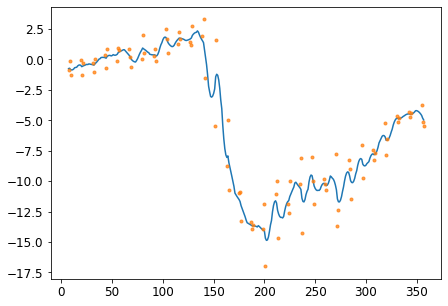

In [53]:
it,jt = 234,567
it,jt = 800,1500
rasar,daylist = create_rasar(data[:,it,jt],mdatelist,mpfulist,radays=7)
# print(rasar)
rasmooth = rasar_smoothing(rasar,daylist)
# print(rasar)
# print(timediff(datetime(2021,1,1,0,0,0),datetime(2022,1,1,0,0,0),form='days'))
# print(np.isnan(rasar))

plt.figure(figsize=(7,5))
plt.plot(rasmooth,'-')
rasar,daylist = create_rasar(data[:,it,jt],mdatelist,mpfulist,radays=1)
# rasar = rasar_smoothing(rasar,daylist,radays=1)
plt.plot(rasar,'.',alpha=.75)
plt.savefig(data_dir/'figures'/f'pt_i{it}_j{jt}.png')
# plt.plot(data[:,it,jt],'.')
# data[:,it,jt]

In [ ]:
# it,jt = 825,835
it,jt = 800,825
meltvec = getmeltvec(data[:,it,jt],mpfulist,mpfunique,mdatelist,wstart,wend)
dstart,dend,dstartstd,dendstd = meltseason(meltvec,mdatelist)

mslen = []
mssig = []
for i,x in enumerate(dstart):
    mslen.append((dend[i]-dstart[i]).days+(dend[i]-dstart[i]).seconds/86400)
    mssig.append(np.sqrt(dstartstd[i]**2+dendstd[i]**2))
print(dstart)
print(dend)
print(' ')
print(dstartstd)
print(dendstd)
print(' ')
print(mslen)
print(mssig)

mslen = []
mssigsum = 0

for i,x in enumerate(dstart):
    mslen.append((dend[i]-dstart[i]).days+(dend[i]-dstart[i]).seconds/86400)
    # mssig.append(np.sqrt(dstartstd[i]**2+dendstd[i]**2))
    mssigsum += dstartstd[i]**2+dendstd[i]**2
mssig = np.sqrt(mssigsum)

print(' ')
print(mssig)

In [21]:
#I want this to: do advec/rasar for each day
#make a fullvec for start and end days

d1=np.min(mdatelist)
d2=np.max(mdatelist)
# timediff(d1,d2)

klen,ilen,jlen = np.shape(data)
print(np.shape(data))

365/klen*5.0
#for ii,jj,etc:
# create_rasar(data[ii,jj],mdatelist,mpfulist,radays=7)

In [5]:
#Make Adjusted images:

# def adjust_data(data,pfmulist,pfunique,datelist,wstart,wend,setdb=0):
def adjust_data(data,pfmulist,pfunique,datelist,setdb=0):
    """adjusts dvec so that the winter mean of each path becomes 0"""
    
    addata = data
    if type(datelist)==tuple:
        datelist = np.array(datelist)
    
    year = datelist[0].year
    wstart = datetime(year,1,1,0,0,0)
    start_date = datetime(year,1,1,0,0,0) 
    wend = datetime(year,4,1,0,0,0)
    end_date = datetime(year+1, 1, 1,0,0,0)
    
    
    for pfu in pfunique:

        cdata = data[pfmulist==pfu]
        # cvec = advec[pfmulist==pfu]
        cdatelist = datelist[pfmulist==pfu]
        # cmeltcube = meltcube[mpfulist==pfu]
    
        winterlist = np.zeros(len(cdatelist))
        winterlist[(cdatelist > wstart) & (cdatelist < wend)] = 1
        winterlist = np.array(winterlist,dtype=bool)
        
        # dstack = dstack[winterlist]
        # print(cvec[winterlist])
        adjustval = np.nanmean(cdata[winterlist],axis=0)
        # adjustval = np.nanmean(cdata[winterlist],axis=0)+setdb
        
        addata[mpfulist==pfu] = cdata - adjustval
        # print(cdata)
    return addata

In [8]:
# mnamelist[0]
# pnamelist[100]
# plt.close('all')
# str(mdatelist[5].date())
print(np.shape(data))

(126, 2403, 2140)


In [6]:
#Make adjusted plots

data = adjust_data(data,mpfulist,mpfunique,mdatelist)

pols = ['VV']

for pol in pols:
    #Make some darn pretty pictures:
    # fileloc = clipped_path/pol
    # filelist = glob.glob(f'{fileloc}/*')
    # figurepath = fileloc.replace('rtc_clipped','figures')
    figurepath = data_dir/'figures'
    for i,name in enumerate(mnamelist):
        # fname = file.split('rtc_clipped/')[1]
        # fname = name.replace(str(fileloc),str(figurepath))
        # fname = fname.replace('_VV.tif','.png')
        # fname = fname.replace('S1A_','')
        # fname = fname.replace('S1B_','')
        # fname = fname.replace('.tif','.png')
        # print(file)
        # ds = gdal.Open(file)
        # sarmap = ds.ReadAsArray()
        # ds = None
        sarmap = data[i]
        sarmap[sarmap<-40]=np.nan
        plt.figure(figsize=(7,7))
        plt.imshow(sarmap,vmin=-15,vmax=7,cmap='Greys_r')
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        fname = f'{str(figurepath)}/adjusted_{name}.png'
        fname = fname.replace('S1A_','')
        fname = fname.replace('S1B_','')
        plt.text(10,100,mdatelist[i].date(),fontsize=18)
        plt.savefig(fname,bbox_inches='tight')
        plt.close()
        # print(np.shape(sarmap))

        # print(file)
        # print(fname)

    # print(filelist)
    
pols = ['VV','VH']